# Submission by ATUL ANANT~MDS202314

### Importing important packages and libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import compute_class_weight
from transformers import BertModel, BertTokenizerFast

device(type='cuda')

### Reading text data using read_csv as data is stored in csv files here

In [ ]:
train_df = pd.read_csv(r"D:\aml_final\Assignment5\sentiment-analysis-dataset\train.csv", encoding="ISO-8859-1")[['text', 'sentiment']]
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
test_df = pd.read_csv(r"D:\aml_final\Assignment5\sentiment-analysis-dataset\test.csv", encoding="ISO-8859-1")[['text', 'sentiment']]
test_df.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [8]:
# Unique classes
train_df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [10]:
# Check for missing values
train_df['text'].isna().sum(), test_df['text'].isna().sum()

(1, 1281)

In [11]:
# Remove missing values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
# Encode the labels
label_encoding = {'neutral': 0, 'negative': 1, 'positive': 2}
train_df.loc[:, 'label'] = train_df.loc[:, 'sentiment'].map(label_encoding)
test_df.loc[:, 'label'] = test_df.loc[:, 'sentiment'].map(label_encoding)

# Split the DataFrame (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
print(len(train_df), len(val_df))

21984 5496


## Loading BERT 

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize datasets
datasets = {'train': train_df, 'val': val_df, 'test': test_df}
tokens = {
    split: tokenizer.batch_encode_plus(
        df['text'].tolist(),
        padding='longest',
        max_length=25,
        truncation=True
    )
    for split, df in datasets.items()
}

tokens_train, tokens_val, tokens_test = tokens['train'], tokens['val'], tokens['test']


In [13]:
tokens_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
# Convert tokenized inputs and labels to tensors for train, val, test
tensors = {}
for split, df in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    tok = eval(f"tokens_{split}")
    tensors[split] = {
        'seq': torch.tensor(tok['input_ids']),
        'mask': torch.tensor(tok['attention_mask']),
        'y': torch.tensor(df['label'].tolist())
    }

train_seq, train_mask, train_y = tensors['train']['seq'], tensors['train']['mask'], tensors['train']['y']
val_seq, val_mask, val_y = tensors['val']['seq'], tensors['val']['mask'], tensors['val']['y']
test_seq, test_mask, test_y = tensors['test']['seq'], tensors['test']['mask'], tensors['test']['y']

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define batch size
batch_size = 32

# Create dataloaders for train, val, test
dataloaders = {}
for split, is_train in zip(['train', 'val', 'test'], [True, False, False]):
    seq, mask, y = eval(f"{split}_seq"), eval(f"{split}_mask"), eval(f"{split}_y")
    dataset = TensorDataset(seq, mask, y)
    sampler = RandomSampler(dataset) if is_train else SequentialSampler(dataset)
    dataloaders[f"{split}_dataloader"] = DataLoader(dataset, sampler=sampler, batch_size=batch_size)

# Unpack if you still want individual variables
train_dataloader = dataloaders['train_dataloader']
val_dataloader = dataloaders['val_dataloader']
test_dataloader = dataloaders['test_dataloader']


In [16]:
# import BERT-base pretrained model
bert = BertModel.from_pretrained('bert-base-uncased')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## My BERT class for smooth handling of use cases!

In [19]:
class BERTModel(nn.Module):
    def __init__(self, bert):
        super(BERTModel, self).__init__()
        for layer in list(bert.children())[:-1]:
            for parameter in layer.parameters():
                parameter.requires_grad = False
        bert.pooler.dense = nn.Linear(in_features=768, out_features=len(label_encoding), bias=True)
        self.bert = bert
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, sent_id, mask):
        out = self.bert(sent_id, attention_mask=mask)
        x = self.softmax(out.pooler_output)
        return x

model = BERTModel(bert)
model = model.to(device)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_y.numpy()), y=train_y.numpy())

In [24]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)
cross_entropy  = nn.NLLLoss(weight=weights) 

# define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-4)
# number of training epochs
epochs = 30

### Training

In [22]:
def train():
    model.train()
    total_loss = 0
    total_preds = []

    progress_bar = tqdm(train_dataloader, desc="Training")
    for batch in progress_bar:
        # Push batch to GPU
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # Clear previously calculated gradients
        model.zero_grad()

        # Get model predictions for the current batch
        preds = model(sent_id, mask)

        # Compute the loss
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Move predictions to CPU and store them
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

        # Update tqdm progress bar with loss
        progress_bar.set_postfix(loss=loss.item())

    # Compute the average loss
    avg_loss = total_loss / len(train_dataloader)

    # Reshape predictions (no. of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

### Model evaluation definitions

In [23]:
def evaluate():
    # Deactivate dropout layers
    model.eval()
    
    total_loss = 0
    total_preds = []

    # Wrap val_dataloader with tqdm for progress tracking
    progress_bar = tqdm(val_dataloader, desc="Evaluating", leave=True)

    for batch in progress_bar:
        # Push batch to GPU
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        # Deactivate autograd
        with torch.no_grad():
            # Get model predictions
            preds = model(sent_id, mask)

            # Compute validation loss
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

            # Move predictions to CPU and store them
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

            # Update tqdm progress bar with loss
            progress_bar.set_postfix(loss=loss.item())

    # Compute the average validation loss
    avg_loss = total_loss / len(val_dataloader)

    # Reshape predictions (no. of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

### Training logic

In [27]:
# Set initial best validation loss to infinite
best_valid_loss = float('inf')

# Lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# Training loop with tqdm progress bar
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Train model with progress tracking
    train_loss, _ = train()

    # Evaluate model with progress tracking
    valid_loss, _ = evaluate()

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), r'D:\aml_final\Assignment5\model_pth\bert_model.pth')

    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Display epoch summary with tqdm-style formatting
    print(f"Training Loss: {train_loss:.3f} | Validation Loss: {valid_loss:.3f}")


Epoch 1/30


Evaluating: 100%|██████████| 172/172 [00:06<00:00, 28.54it/s, loss=0.868]


Training Loss: 0.842 | Validation Loss: 0.819

Epoch 2/30


Evaluating: 100%|██████████| 172/172 [00:06<00:00, 28.00it/s, loss=0.912]


Training Loss: 0.833 | Validation Loss: 0.808

Epoch 3/30


Evaluating: 100%|██████████| 172/172 [00:06<00:00, 27.53it/s, loss=0.962]


Training Loss: 0.828 | Validation Loss: 0.816

Epoch 4/30


Evaluating: 100%|██████████| 172/172 [00:06<00:00, 27.90it/s, loss=0.916]


Training Loss: 0.824 | Validation Loss: 0.803

Epoch 5/30


Evaluating: 100%|██████████| 172/172 [00:06<00:00, 27.13it/s, loss=0.918]


Training Loss: 0.819 | Validation Loss: 0.799

Epoch 6/30


Evaluating: 100%|██████████| 172/172 [00:06<00:00, 26.64it/s, loss=0.911]


Training Loss: 0.819 | Validation Loss: 0.796

Epoch 7/30


Evaluating: 100%|██████████| 172/172 [00:06<00:00, 26.30it/s, loss=0.929]


Training Loss: 0.816 | Validation Loss: 0.796

Epoch 8/30


Evaluating: 100%|██████████| 172/172 [00:06<00:00, 25.15it/s, loss=0.879]


Training Loss: 0.816 | Validation Loss: 0.793

Epoch 9/30


Evaluating: 100%|██████████| 172/172 [00:06<00:00, 25.02it/s, loss=0.904]


Training Loss: 0.811 | Validation Loss: 0.789

Epoch 10/30


Evaluating: 100%|██████████| 172/172 [00:06<00:00, 25.06it/s, loss=0.903]


Training Loss: 0.811 | Validation Loss: 0.787

Epoch 11/30


Evaluating: 100%|██████████| 172/172 [00:06<00:00, 24.80it/s, loss=0.913]


Training Loss: 0.813 | Validation Loss: 0.790

Epoch 12/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 24.39it/s, loss=0.939]


Training Loss: 0.810 | Validation Loss: 0.797

Epoch 13/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 24.11it/s, loss=0.927]


Training Loss: 0.811 | Validation Loss: 0.792

Epoch 14/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 24.04it/s, loss=0.904]


Training Loss: 0.807 | Validation Loss: 0.786

Epoch 15/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 24.12it/s, loss=0.926]


Training Loss: 0.807 | Validation Loss: 0.790

Epoch 16/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 24.05it/s, loss=0.954]


Training Loss: 0.808 | Validation Loss: 0.799

Epoch 17/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 24.13it/s, loss=0.933]


Training Loss: 0.804 | Validation Loss: 0.788

Epoch 18/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 23.81it/s, loss=0.914]


Training Loss: 0.805 | Validation Loss: 0.786

Epoch 19/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 23.88it/s, loss=0.891]


Training Loss: 0.804 | Validation Loss: 0.787

Epoch 20/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 23.69it/s, loss=0.881]


Training Loss: 0.805 | Validation Loss: 0.786

Epoch 21/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 23.91it/s, loss=0.937]


Training Loss: 0.804 | Validation Loss: 0.799

Epoch 22/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 23.89it/s, loss=0.913]


Training Loss: 0.802 | Validation Loss: 0.784

Epoch 23/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 23.64it/s, loss=0.926]


Training Loss: 0.804 | Validation Loss: 0.787

Epoch 24/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 23.86it/s, loss=0.917]


Training Loss: 0.804 | Validation Loss: 0.787

Epoch 25/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 23.80it/s, loss=0.91] 


Training Loss: 0.803 | Validation Loss: 0.782

Epoch 26/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 24.43it/s, loss=0.91] 


Training Loss: 0.806 | Validation Loss: 0.782

Epoch 27/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 24.21it/s, loss=0.912]


Training Loss: 0.802 | Validation Loss: 0.782

Epoch 28/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 24.06it/s, loss=0.909]


Training Loss: 0.803 | Validation Loss: 0.781

Epoch 29/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 23.68it/s, loss=0.934]


Training Loss: 0.800 | Validation Loss: 0.791

Epoch 30/30


Evaluating: 100%|██████████| 172/172 [00:07<00:00, 23.62it/s, loss=0.893]

Training Loss: 0.799 | Validation Loss: 0.783


### Visualisation

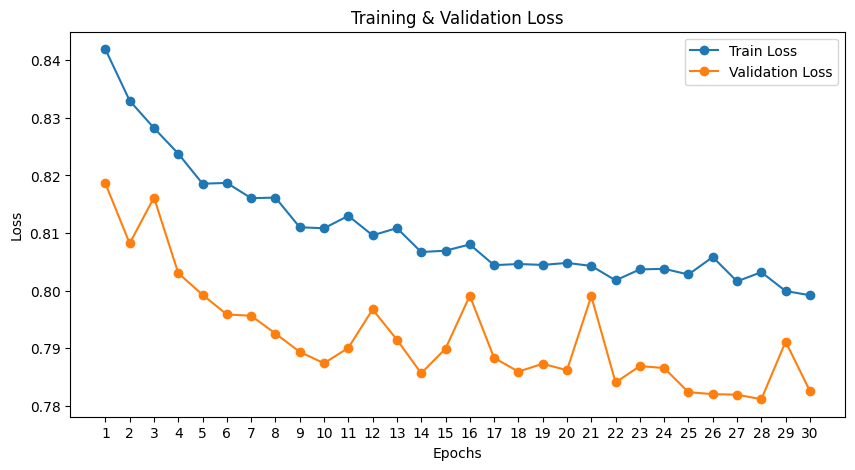

In [28]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss', marker='o')
plt.xticks(range(1, epochs + 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

### Model metrics summary with details

In [29]:
#load weights of best model
path = r'D:\aml_final\Assignment5\model_pth\bert_model.pth'
model.load_state_dict(torch.load(path))

# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.70      0.52      0.60      1430
           1       0.60      0.78      0.67      1001
           2       0.68      0.72      0.70      1103

    accuracy                           0.66      3534
   macro avg       0.66      0.67      0.66      3534
weighted avg       0.66      0.66      0.65      3534

